# Autoencoder for Fraud Detection
---
Taken from [Fraud Detection Handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) and [Robin Teuwen's Kaggle notebook](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders)

Data taken from [Machine Learning Group ULB's Credit Card Fraud dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## Pre-Requisites

### Importing the Libraries

In [1]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Importing PyTorch
import torch

# Importing datapreprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing metrics from Scikit-Learn
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
# Checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [3]:
# Create the PyTorch model path if it doesn't exist
if not os.path.exists("Models//PyTorch"):
    os.makedirs("Models//PyTorch")

# Set the model path
model_path = "Models//PyTorch"

### Importing the Dataset

In [4]:
# Importing the data in
data = pd.read_csv("Dataset//creditcard.csv")

# Previewing the data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In [5]:
# Getting the shape of the data
data.shape

(284807, 31)

In [6]:
# Getting a description of the data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Checking for missing values
(data.isnull().sum() != 0).sum()

0

In [8]:
# Removing the time column
data = data.drop("Time", axis=1)

In [9]:
# Checking the distribution of the target variable
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

## Data Preprocessing

In [10]:
# Manually undersampling the data
fraud = data[data["Class"] == 1]
not_fraud = data[data["Class"] == 0]

In [11]:
# Selecting 492 random non-fraudulent transactions
X_dev_not_fraud = not_fraud.sample(n=fraud.shape[0], random_state=42)

# Separating the remaining non-fraudulent transactions and the fraudulent transactions for the dev set
X_dev = pd.concat([X_dev_not_fraud, fraud], axis=0)
y_dev = X_dev["Class"]
X_dev = X_dev.drop("Class", axis=1)

# Getting only the non-fraudulent transactions for the training set and the dev set
X_train = not_fraud.drop(X_dev_not_fraud.index)
y_train = X_train["Class"]
X_train = X_train.drop("Class", axis=1)

# Separating the remaining non-fraudulent transactions and the fraudulent transactions for the test set
X_dev = pd.concat([not_fraud.drop(X_train.index), fraud], axis=0)
y_dev = X_dev["Class"]
X_dev = X_dev.drop("Class", axis=1)

# Splitting the training data into train and dev sets
X_train, X_train_dev, y_train, y_train_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)

# Transforming the data
X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)
X_train_dev = scaler.transform(X_train_dev)

# Creating data loaders
X_train = torch.FloatTensor(X_train).to(device)
X_dev = torch.FloatTensor(X_dev).to(device)
X_train_dev = torch.FloatTensor(X_train_dev).to(device)

## Autoencoder

### Building the Encoder

In [13]:
# Creating the encoder class
class Encoder(torch.nn.Module):
    def __init__(self, input_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, 16)
        self.linear2 = torch.nn.Linear(16, 8)
        self.linear3 = torch.nn.Linear(8, 4)
        self.linear4 = torch.nn.Linear(4, 2)
        self.activation = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)
        return x

### Building the Decoder

In [14]:

# Creating the decoder class
class Decoder(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, 4)
        self.linear2 = torch.nn.Linear(4, 8)
        self.linear3 = torch.nn.Linear(8, 16)
        self.linear4 = torch.nn.Linear(16, output_size)
        self.activation = torch.nn.ELU()
        
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)

        return x

### Building the Autoencoder

In [15]:
# Creating the model class
class Autoencoder(torch.nn.Module):
    def __init__(self, input_size, dropout=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size, dropout=dropout)
        self.decoder = Decoder(2, input_size)
        
    def forward(self, x, train=True):

        if not train:
            with torch.no_grad():
                x = self.encoder(x)
                x = self.decoder(x)
                return x
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x 


In [16]:
# Setting the hyperparameters
input_size = X_train.shape[1]
learning_rate = 1e-3
epochs = 1000
dropout_rate = 0.2
batch_size = 2048
early_stopping_patience = 100

In [17]:
# Batching the training set
X_train_batched = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [18]:
# Random seed for reproducibility
torch.manual_seed(42)

# Creating the model
model = Autoencoder(input_size=input_size, dropout=dropout_rate).to(device)

# Printing the model architecture
print(model.parameters)

<bound method Module.parameters of Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=29, out_features=16, bias=True)
    (linear2): Linear(in_features=16, out_features=8, bias=True)
    (linear3): Linear(in_features=8, out_features=4, bias=True)
    (linear4): Linear(in_features=4, out_features=2, bias=True)
    (activation): ELU(alpha=1.0)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=8, bias=True)
    (linear3): Linear(in_features=8, out_features=16, bias=True)
    (linear4): Linear(in_features=16, out_features=29, bias=True)
    (activation): ELU(alpha=1.0)
  )
)>


### Training the Autoencoder

In [19]:
# Defining the loss function
criterion = torch.nn.MSELoss()

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Creating the training loop
def training_loop(model, criterion, optimizer, epochs, X_train, X_dev, early_stopping_patience=0, 
                  model_checkpoint_path=None):
    
    # Pretty printing the start of training message
    print('===' * 10 + 'START OF TRAINING' + '===' * 10)

    # Creating lists to store the training and dev losses
    train_loss = []
    dev_loss = []

    # Creating variables to store the best epoch and the best dev loss
    best_epoch = 0
    best_dev_loss = np.inf

    # Creating the training loop
    for epoch in range(epochs):
        # Setting the model to training mode
        model.train()

        # Creating a variable to store the running loss for the training set
        running_loss = 0.0

        # Training the model on the training set
        for data in X_train:

            # Zeroing the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Adding the loss to the running loss
            running_loss += loss.item()
        
        # Appending the training loss
        train_loss.append(running_loss / len(X_train))

        # Calculating the dev loss
        with torch.no_grad():
            # Setting the model to evaluation mode
            model.eval()
            
            # Calculating the dev loss
            outputs = model(X_dev)
            loss = criterion(outputs, X_dev)

            # Appending the dev loss
            dev_loss.append(loss.item())

        # Printing the epoch, training loss and dev loss
        print("Epoch: {}    |   Train Loss: {:.5f}  |   Dev Loss: {:.5f}".format(epoch + 1, train_loss[-1], dev_loss[-1]))

        # Early stopping logic
        if epoch > early_stopping_patience and early_stopping_patience != 0:
            
            # Saving the model if the dev loss is the best so far
            if dev_loss[-1] < best_dev_loss and model_checkpoint_path is not None:
                best_dev_loss = dev_loss[-1]
                best_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(model_path, model_checkpoint_path))

            # Early stopping if the best_dev_loss is equal to the dev loss of early_stopping_patience epochs ago
            if best_dev_loss == dev_loss[-early_stopping_patience]:
                print(f"Early Stopping at {epoch + 1}")
                break

    # Reloading the best model if model_checkpoint_path is not None
    if model_checkpoint_path is not None:
        print("Best epoch: {}   |   Best dev loss: {:.5f}".format(best_epoch, best_dev_loss))
        model.load_state_dict(torch.load(os.path.join(model_path, model_checkpoint_path)))
        model.train()
    
    return {"train_loss": train_loss, "dev_loss": dev_loss}

In [21]:
# # Training the model
# losses = training_loop(model, criterion, optimizer, epochs, 
#                                          X_train_batched, X_train_dev, 
#                                          early_stopping_patience=early_stopping_patience, 
#                                          model_checkpoint_path="checkpoint_best.pt")

# # Saving the losses
# joblib.dump(losses, os.path.join(model_path, "losses.pkl"))

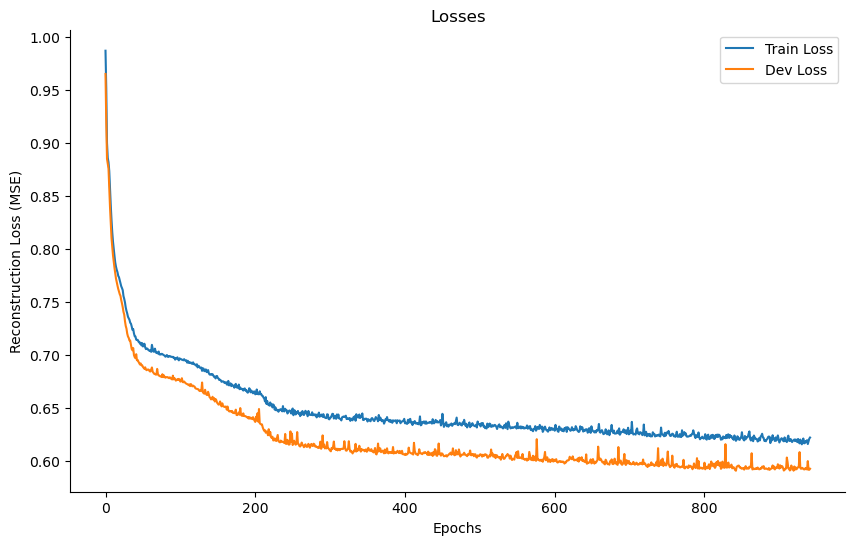

In [22]:
# Reloading the losses
losses = joblib.load(os.path.join(model_path, "losses.pkl"))

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the training and dev losses
plt.plot(losses['train_loss'], label="Train Loss")
plt.plot(losses['dev_loss'], label="Dev Loss")

# Plot settings
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Losses")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

In [23]:
# # Saving the model
# torch.save(model, os.path.join(model_path, "fraud_autoencoder.pt"))

# Loading the model
model = torch.load(os.path.join(model_path, "fraud_autoencoder.pt"))
model.eval() # Setting the model to evaluation mode

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=29, out_features=16, bias=True)
    (linear2): Linear(in_features=16, out_features=8, bias=True)
    (linear3): Linear(in_features=8, out_features=4, bias=True)
    (linear4): Linear(in_features=4, out_features=2, bias=True)
    (activation): ELU(alpha=1.0)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=8, bias=True)
    (linear3): Linear(in_features=8, out_features=16, bias=True)
    (linear4): Linear(in_features=16, out_features=29, bias=True)
    (activation): ELU(alpha=1.0)
  )
)

### Evaluating the Raw Autoencoder Output

In [24]:
# Getting the predictions
predictions = model.eval()(X_dev, train=False) # Don't forget to set model.train() when training again train=True

# Getting the MSE
dev_mse = torch.mean(torch.square(X_dev - predictions), dim=1).detach().cpu().numpy()

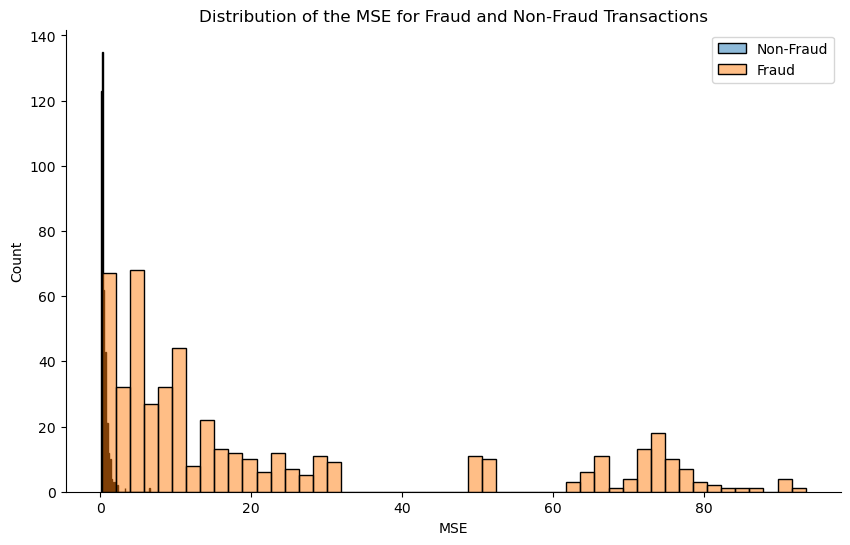

In [25]:
# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the distribution of the MSE for fraud and non-fraud transactions
sns.histplot(dev_mse[y_dev == 0], label="Non-Fraud", fill=True, alpha=0.5, bins=50)
sns.histplot(dev_mse[y_dev == 1], label="Fraud", fill=True, alpha=0.5, bins=50)

# Plot settings
plt.xlabel("MSE")
plt.title("Distribution of the MSE for Fraud and Non-Fraud Transactions")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

In [26]:
# Getting the mean and standard deviation of the MSE for fraud and non-fraud transactions
print("Non-Fraud Mean MSE: {:.5f} Non-Fraud Std MSE: {:.5f}".format(np.mean(dev_mse[y_dev == 0]), np.std(dev_mse[y_dev == 0])))
print("Fraud Mean MSE: {:.5f} Fraud Std MSE: {:.5f}".format(np.mean(dev_mse[y_dev == 1]), np.std(dev_mse[y_dev == 1])))

Non-Fraud Mean MSE: 0.52024 Non-Fraud Std MSE: 0.47587
Fraud Mean MSE: 22.67341 Fraud Std MSE: 26.06974


## Classifier Evaluation

### Precision-Recall Curve

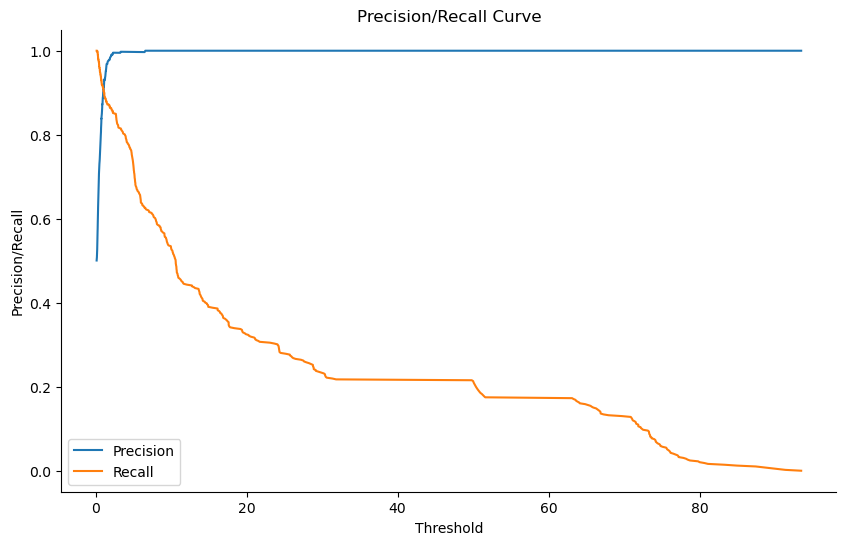

In [27]:
# Calculating the precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_dev, dev_mse)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the precision and recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")

# Plot settings
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.title("Precision/Recall Curve")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

### Receiver Operating Characteristic (ROC) Curve & Area Under Curve (AUC)

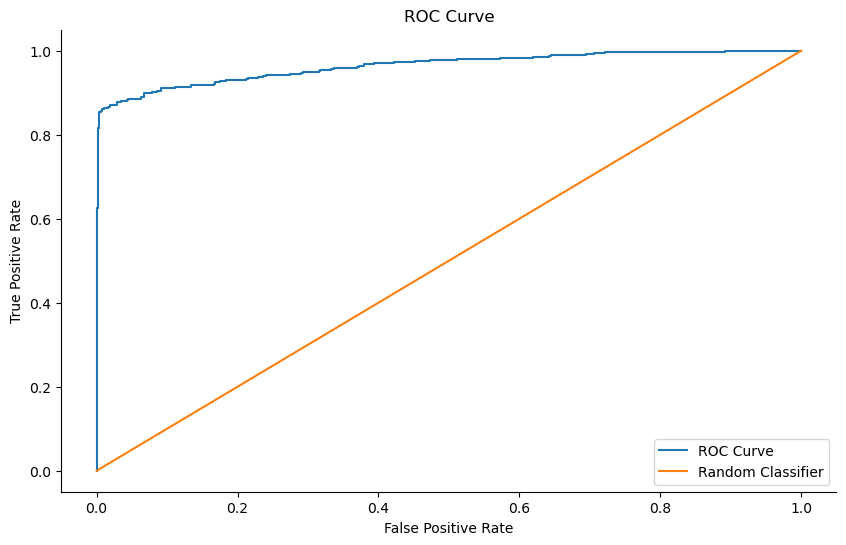

In [28]:
# Calculating the FPR and TPR score at different thresholds
fpr, tpr, thresholds = roc_curve(y_dev, dev_mse)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the ROC curve
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], label="Random Classifier")

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
sns.despine()

#
plt.show()

In [29]:
# Getting the AUC
auc = roc_auc_score(y_dev, dev_mse)
print("AUC: {:.5f}".format(auc))

AUC: 0.96338


### Threshold Selection, Confusion Matrix, and Classification Report

In [30]:
# Deciding the threshold
threshold = 1

# Getting the predictions
y_dev_pred = np.where(dev_mse > threshold, 1, 0)

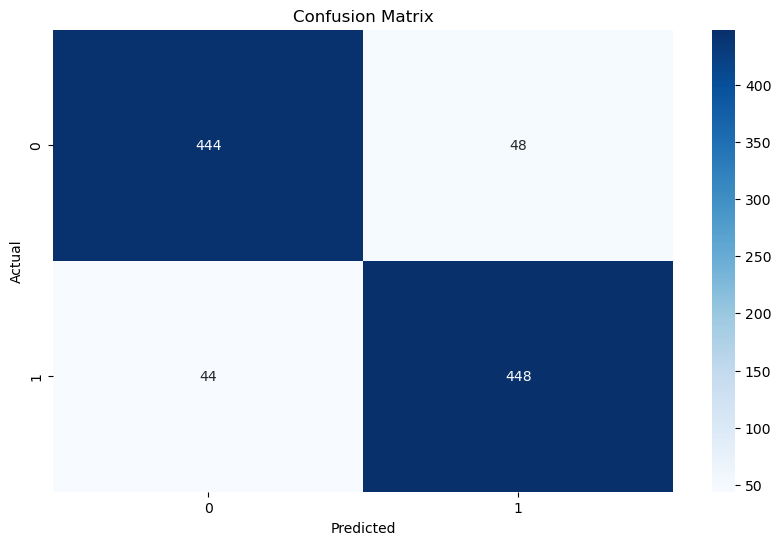

In [31]:
# Creating the confusion matrix
cm = confusion_matrix(y_dev, y_dev_pred)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Plot settings
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Showing the plot
plt.show()

In [32]:
# Getting the classification report
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       492
           1       0.90      0.91      0.91       492

    accuracy                           0.91       984
   macro avg       0.91      0.91      0.91       984
weighted avg       0.91      0.91      0.91       984

